In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt


I have recently purchased new golf clubs, which I believe will significantly improve my game. Below are the scores of three rounds of golf played at three different golf courses with the old and the new clubs.

### Q1: Conduct an analysis of variance. Using 𝛼 = 0.05, what conclusions can you draw?

In [2]:
# Data

data = {
    "Clubs": ["Old", "Old", "Old", "New", "New", "New"],
    "Ahwatukee": [90, 87, 86, 88, 87, 85],
    "Karsten": [91, 93, 90, 90, 91, 88],
    "Foothills": [88, 86, 90, 86, 85, 88]
}

df = pd.DataFrame(data)
df

,Clubs,Ahwatukee,Karsten,Foothills
0,Old,90,91,88
1,Old,87,93,86
2,Old,86,90,90
3,New,88,90,86
4,New,87,91,85
5,New,85,88,88


In [3]:
# Convert to long (tidy) format for ANOVA
df_long = df.melt(id_vars="Clubs", var_name="Course", value_name="Score")

In [4]:
# --- Two-way ANOVA with interaction ---
model = ols("Score ~ C(Clubs) * C(Course)", data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Long data:")
print(df_long, "\n")
print("Two-way ANOVA (typ=2):")
print(anova_table)

Long data:
   Clubs     Course  Score
0    Old  Ahwatukee     90
1    Old  Ahwatukee     87
2    Old  Ahwatukee     86
3    New  Ahwatukee     88
4    New  Ahwatukee     87
5    New  Ahwatukee     85
6    Old    Karsten     91
7    Old    Karsten     93
8    Old    Karsten     90
9    New    Karsten     90
10   New    Karsten     91
11   New    Karsten     88
12   Old  Foothills     88
13   Old  Foothills     86
14   Old  Foothills     90
15   New  Foothills     86
16   New  Foothills     85
17   New  Foothills     88 

Two-way ANOVA (typ=2):
                       sum_sq    df         F    PR(>F)
C(Clubs)             9.388889   1.0  3.188679  0.099424
C(Course)           44.444444   2.0  7.547170  0.007548
C(Clubs):C(Course)   0.444444   2.0  0.075472  0.927743
Residual            35.333333  12.0       NaN       NaN


### Q2: Do you have any recommendations or suggestions for me?

Answer: Only course is significant. 

Since there is no interaction, so:

New clubs are not better on one course and worse on another.
Old vs New behaves the same across all courses.

So you cannot make recommendations like:

“Use old clubs only at Foothills”

“Use new clubs only at Karsten”

Those would require a significant interaction, which we do not have.

In [5]:
df_long[["Course", "Score"]].groupby(["Course"]).mean().reset_index()

,Course,Score
0,Ahwatukee,87.166667
1,Foothills,87.166667
2,Karsten,90.500000


In [6]:
df_long[["Course", "Clubs", "Score"]].groupby(["Course", "Clubs"]).mean().reset_index()

,Course,Clubs,Score
0,Ahwatukee,New,86.666667
1,Ahwatukee,Old,87.666667
2,Foothills,New,86.333333
3,Foothills,Old,88.000000
4,Karsten,New,89.666667
5,Karsten,Old,91.333333


### 1. Residuals vs. Fitted values

This checks if residuals are randomly scattered (no pattern = good).

Check: constant variance assumption and independence assumption

In [7]:
# Residuals
fitted = model.fittedvalues
residuals = model.resid

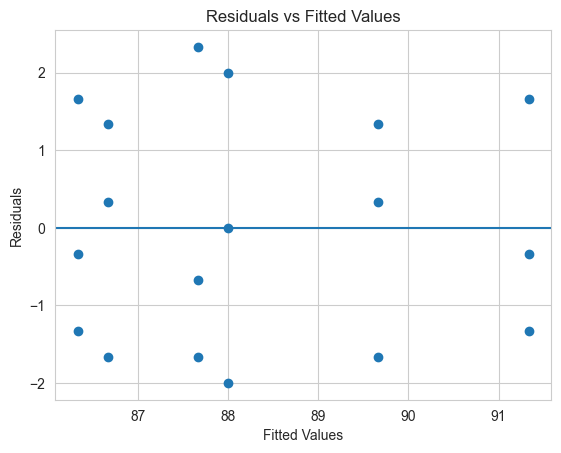

In [8]:

# Plot
plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


### 2. QQ Plot of residuals: Check normality of residuals assumption

<Figure size 640x480 with 0 Axes>

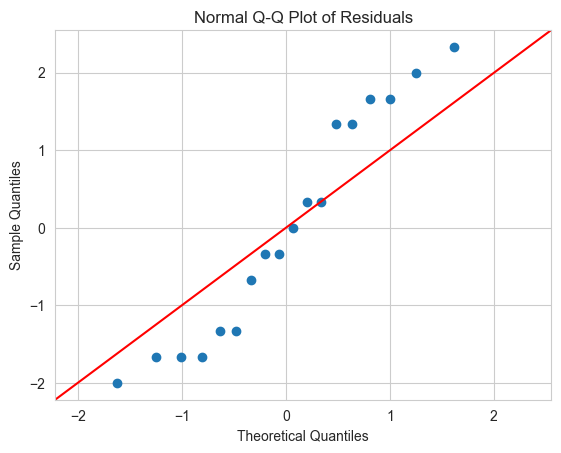

In [9]:
# Q-Q plot
plt.figure()
sm.qqplot(residuals, line="45")
plt.title("Normal Q-Q Plot of Residuals")
plt.show()


The residual plots show no devaiations from the assumptions.